In [1]:
!pip install numpy torch sympy mod blobfile pandas seaborn matplotlib tqdm einops wandb

import sys
import os

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))

from contextlib import suppress
from dataclasses import dataclass, asdict
from datetime import datetime
from typing import Callable, Literal, Optional, Union, Tuple, List
from copy import deepcopy

import numpy as np
import pandas as pd
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch import optim
import wandb
from tqdm.notebook import tqdm
import ipywidgets as widgets
import wandb

import matplotlib as mpl
from matplotlib.colors import LogNorm
import seaborn as sns
import matplotlib.pyplot as plt

from patterns.dataset import ModularArithmetic, Operator
from patterns.transformer import Transformer
from patterns.utils import generate_run_name
from patterns.learner import Config, GrokkingLearner, GrokkingConfig

from unifying.sweep import get_history, handle_outliers

DEFAULT_MODULUS = 113
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

sns.set_theme(style="darkgrid")


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


# Unifying Grokking & DD

In [7]:
config = GrokkingConfig(
    lr=1e-3,
    d_model=32,
    weight_decay=.3,
    test_acc_criterion=1.,
    device=DEVICE,  
    modulus=1000
)

# ModularArithmetic.generate(
#     modulus=2000,
#     operator="+",
# )
GrokkingLearner.create(config, train_dataloader, val_dataloader)

Model has 76608 trainable parameters


In [5]:
# Dataset

train_dataset, val_dataset = ModularArithmetic.generate_split(
    operator=config.operator,
    modulus=config.modulus,
    frac_label_noise=config.frac_label_noise,
    seed=config.seed,
    shuffle=config.shuffle,
    frac_train=config.frac_train,
)

# Dataloaders

train_dataloader = DataLoader(train_dataset, batch_size=config.batch_size)
val_dataloader = DataLoader(val_dataset, batch_size=config.batch_size)

In [4]:
# Logging
date_time = datetime.now().strftime("%Y%m%d-%H%M%S-%f")
mode = "disabled" if config.no_logging else None

In [5]:
# Training

def train_test_run():
    learner = GrokkingLearner.create(config, train_dataloader, val_dataloader)

    if config.resume_run_id is None:
        wandb.init(
            project=config.wandb_project,
            id=date_time,
            settings=wandb.Settings(start_method="thread"),
            name=learner.name,
            config=asdict(config),
            mode=mode,
        )
    else:
        wandb.init(
            project=config.wandb_project,
            id=config.resume_run_id,
            resume="must",
            settings=wandb.Settings(start_method="thread"),
            name=learner.name,
            config=asdict(config),
            mode=mode,
        )
    wandb.watch(learner.model)
    
    try: 
        learner.train()
    except KeyboardInterrupt:
        wandb.finish()


train_test_run()

Model has 226816 trainable parameters


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: jqhoogland. Use `wandb login --relogin` to force relogin


  0%|          | 0/100000 [00:00<?, ?it/s]

Test accuracy criterion reached


# Sweeps

To initialize a sweep, run the following command:

```shell
wandb sweep --project grokking <config.yml>
```

where `<config.yml>` is the config file you want to use.

To run the sweep, run the following command:

```shell
wandb agent <sweep_id> --function train
```

where `<sweep_id>` is the id of the sweep you want to run. You can find the sweep id by running `wandb sweep ls`.

You can pass an optional `--count` flag to the `wandb agent` command to specify the number of runs you want to execute. If you don't pass this flag, the agent will run until all the runs in the sweep are complete (for a grid sweep).

On a multi-GPU machine, you can run multiple agents in parallel through the following:

```shell
CUDA_VISIBLE_DEVICES=0 wandb agent <sweep_id> &
CUDA_VISIBLE_DEVICES=1 wandb agent <sweep_id> &
...
```

In [4]:
import json
import numpy as np

def generate_coarse_to_fine_grid_sweep(min_, max_, total_steps, step_sizes=[10, 5, 3, 1], type_="log"):
    if type_ == "log":
        # Generate the logscale range
        grid = np.logspace(np.log10(min_), np.log10(max_), total_steps)
    elif type_ == "linear":
        grid = np.linspace(min_, max_, total_steps)
    else:
        grid = np.arange(min_, max_, int((max_ - min_) / total_steps))

    # Initialize an empty list to store the rearranged elements
    rearranged_grid = []

    # Iterate over the step sizes and merge the sublists
    for step in step_sizes:
        for i in range(0, len(grid), step):
            if grid[i] not in rearranged_grid:
                rearranged_grid.append(grid[i])

    return rearranged_grid


def rearrange_coarse_to_fine(grid: List, step_sizes=[10, 5, 3, 1]):
    # Initialize an empty list to store the rearranged elements
    rearranged_grid = []

    # Iterate over the step sizes and merge the sublists
    for step in step_sizes:
        for i in range(0, len(grid), step):
            if grid[i] not in rearranged_grid:
                rearranged_grid.append(grid[i])

    return rearranged_grid

## Model-wise

In [14]:
model_grid = generate_coarse_to_fine_grid_sweep(20, 201, 100, step_sizes=[60, 30, 20, 10, 5, 3, 1], type_="range")
print(model_grid)

[20, 80, 140, 200, 50, 110, 170, 40, 60, 100, 120, 160, 180, 30, 70, 90, 130, 150, 190, 25, 35, 45, 55, 65, 75, 85, 95, 105, 115, 125, 135, 145, 155, 165, 175, 185, 195, 23, 26, 29, 32, 38, 41, 44, 47, 53, 56, 59, 62, 68, 71, 74, 77, 83, 86, 89, 92, 98, 101, 104, 107, 113, 116, 119, 122, 128, 131, 134, 137, 143, 146, 149, 152, 158, 161, 164, 167, 173, 176, 179, 182, 188, 191, 194, 197, 21, 22, 24, 27, 28, 31, 33, 34, 36, 37, 39, 42, 43, 46, 48, 49, 51, 52, 54, 57, 58, 61, 63, 64, 66, 67, 69, 72, 73, 76, 78, 79, 81, 82, 84, 87, 88, 91, 93, 94, 96, 97, 99, 102, 103, 106, 108, 109, 111, 112, 114, 117, 118, 121, 123, 124, 126, 127, 129, 132, 133, 136, 138, 139, 141, 142, 144, 147, 148, 151, 153, 154, 156, 157, 159, 162, 163, 166, 168, 169, 171, 172, 174, 177, 178, 181, 183, 184, 186, 187, 189, 192, 193, 196, 198, 199]


## Sample-wise

In [ ]:
# Frac train 

frac_train_grid = generate_coarse_to_fine_grid_sweep(0, 1.05, 20, step_sizes=[.5, .2, .1, .05], type_="range")
print(frac_train_grid)

In [5]:
# Frac train 
mnist_frac_train_grid = generate_coarse_to_fine_grid_sweep(0.01, .10, 25, step_sizes=[10, 5, 3, 1], type_="log")
print(mnist_frac_train_grid)

[0.01, 0.026101572156825358, 0.06812920690579612, 0.016155980984398736, 0.042169650342858224, 0.01333521432163324, 0.01778279410038923, 0.023713737056616554, 0.03162277660168379, 0.05623413251903491, 0.07498942093324558, 0.1, 0.011006941712522098, 0.012115276586285882, 0.014677992676220698, 0.019573417814876596, 0.021544346900318832, 0.02872984833353664, 0.03480700588428409, 0.03831186849557287, 0.046415888336127774, 0.05108969774506927, 0.061896581889126036, 0.08254041852680181, 0.09085175756516867]


In [5]:
# Modulus

import warnings


def sieve_of_eratosthenes(n):
    """
    Generate all prime numbers between 2 and n using the Sieve of Eratosthenes algorithm.
    """
    # Create a boolean array "prime[0..n]" and initialize
    # all entries it as true. A value in prime[i] will
    # finally be false if i is Not a prime, else true.
    prime = [True for i in range(n+1)]
    p = 2
    while p**2 <= n:
        # If prime[p] is not changed, then it is a prime
        if prime[p]:
            # Update all multiples of p
            for i in range(p**2, n+1, p):
                prime[i] = False
        p += 1

    # Generate list of primes
    primes = [p for p in range(2, n+1) if prime[p]]
    return primes


def primes_range(min_, max_, num_primes):
    """
    Generate a list of primes between min_ and max_, 
    following a near-logarithmic scale with num_primes elements.
    """
    all_primes = [p for p in sieve_of_eratosthenes(max_) if p >= min_]

    # Generate the logscale range
    grid = np.logspace(np.log10(min_), np.log10(max_), num_primes)

    # Find the closest prime to each element in the grid
    primes = []
    used_indices = set()

    for i in range(len(grid)):
        # Find the index of the closest prime to the grid element
        idx = np.argmin(np.abs(np.array(all_primes) - grid[i]))
        
        while idx in used_indices:
            idx += 1

        if idx >= len(all_primes):
            warnings.warn(f"Ran out of primes to choose from. Returning {len(primes)} primes.")
            break

        used_indices.add(idx)
        primes.append(all_primes[idx])

    return primes

modulus_grid = rearrange_coarse_to_fine(primes_range(30, 1000, 31), [10, 5, 3, 1])
print(modulus_grid)

[31, 97, 311, 997, 53, 173, 557, 43, 61, 83, 127, 241, 349, 499, 701, 37, 41, 47, 67, 79, 109, 137, 157, 193, 223, 277, 389, 443, 631, 787, 887]


## Regularization-wise

In [6]:
wds = generate_coarse_to_fine_grid_sweep(0.05, 10, 51)
print(json.dumps(wds))

[0.049999999999999996, 0.14426999059072135, 0.41627660370093655, 1.201124433981431, 3.4657242157757318, 10.0, 0.08493232323171235, 0.24506370946974493, 0.7071067811865475, 2.0402857733683692, 5.887040186524747, 0.06871187569715699, 0.09442643723643111, 0.12976435235830103, 0.17832704098331334, 0.3367757428593863, 0.46280985962343724, 0.6360106709172864, 0.87402972324268, 1.6506302560910038, 2.2683580195698294, 3.1172626855466286, 4.283859323293314, 8.090191470413135, 0.05558922306812267, 0.06180323442635004, 0.07639279571116754, 0.10498184566128109, 0.1167171847313636, 0.16039713377967135, 0.19826123320599312, 0.22042375836898087, 0.27245802423230514, 0.3029145977149917, 0.37442203787486295, 0.5145448104946759, 0.572062924982669, 0.7861503318472239, 0.9717326650701373, 1.0803572776233041, 1.3353914818633272, 1.484667499371428, 1.8351450701767056, 2.5219251989646447, 2.803837248927306, 3.8531383304670337, 4.7627282303001826, 5.29512724014004, 6.545119802794536, 7.2767624945026474, 8.994

# Interpolation

In [7]:
frac_trains = generate_coarse_to_fine_grid_sweep(0.0167, 1., 15, step_sizes=[5, 3, 1], type_="log")
print(json.dumps(frac_trains))

[0.0167, 0.07202123903566399, 0.3106023276785778, 0.040138666638556336, 0.09647380595935064, 0.23187604411707452, 0.5573170800169124, 0.022369964486772486, 0.029964988690985774, 0.05376649983538355, 0.12922847983320082, 0.17310398230828128, 0.4160576670466261, 0.7465367238233578, 1.0]


In [3]:
# Plot the learning curves [(_step, "train/loss")], [(_step, "test/loss")], [(_step, "train/acc")], [(_step, "test/acc")]
# for each value of "weight_decay". Use the "hue" argument to color the lines by "weight_decay".


def plot_curves_2x2(df: pd.DataFrame, title: str, unique_col: str, log_color: bool = True):
    # Set up the subplot
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

    # Define the columns to plot
    columns = [("_step", "train/loss"), ("_step", "test/loss"), 
            ("_step", "train/acc"), ("_step", "test/acc")]
    subtitles = ["Training Loss", "Validation Loss", "Training Accuracy", "Validation Accuracy"]

    n_unique = df[unique_col].nunique()

    # Loop through each column and plot the learning curve
    for i, (column, subtitle) in enumerate(zip(columns, subtitles)):
        row = i // 2
        col = i % 2
        ax = axes[row][col]
        
        if log_color:
            sns.lineplot(data=df, x=column[0], y=column[1], hue=unique_col, hue_norm=LogNorm(), ax=ax)
        else:
            sns.lineplot(data=df, x=column[0], y=column[1], hue=unique_col, ax=ax)

        ax.set_title(subtitle)
        ax.set_xscale('log')
        ax.set_xlabel("Step")
        # ax.set_ylabel(column[1])

        if "loss" in column[1]:
            ax.set_yscale('log')

    # Add a legend to the last subplot (in the form of a heatmap)
    handles, labels = axes[1][1].get_legend_handles_labels()
    axes[1][1].legend(handles=handles[1:], labels=labels[1:], title=title, loc="center", bbox_to_anchor=(0.5, -0.25), ncol=n_unique)

    # Adjust the layout of the subplots
    fig.tight_layout()

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LogNorm
from scipy.ndimage import gaussian_filter

def get_pivot(
        df: pd.DataFrame,
        unique_col: str,
        columns = ["train/loss", "test/loss", "train/acc", "test/acc"],
        reindex: bool = False,
        interpolate: bool = False,
):
    # Create a pivot table with the data
    pivot_table = pd.pivot_table(df, values=columns, index="_step", columns=unique_col)

    if reindex:
        # Fill in the missing values using linear interpolation and gaussian smoothing
        pivot_table = pivot_table.reindex(np.arange(df._step.min(), df._step.max()+1))

    if interpolate:
        # This will be used to fill in the missing values for the first few steps
        pivot_table = pivot_table.interpolate(method="linear").fillna(method="bfill")

    return pivot_table


def extract_slice(df: pd.DataFrame, step: int, unique_col: str):
    df.sort_values(by=unique_col, inplace=True)
    pivot_table = get_pivot(df, unique_col, reindex=True, interpolate=True)
    unique_vals = sorted(df[unique_col].unique())
    slice_ = pivot_table.loc[step]

    return unique_vals, slice_ 

def plot(
        df: pd.DataFrame,
        smooth: Union[bool, float]=False, 
        log_loss=True, 
        cmap="inferno", 
        titles: Optional[dict]=None, 
        unique_col: str = "weight_decay", 
        log_x: bool = True, 
        log_y: bool = True, 
        title: str = "",
        columns = ["train/loss", "test/loss", "train/acc", "test/acc"],
):
    # Set up the subplot
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

    pivot_table = get_pivot(df, unique_col, reindex=True, interpolate=True, columns=columns)
    unique_vals = sorted(df[unique_col].unique())

    # Loop through each column and plot the heatmap
    for i, column in enumerate(columns):
        row = i // 2
        col = i % 2
        ax = axes[row][col]

        # Create a meshgrid for the x and y edges
        X, Y = np.meshgrid(unique_vals, pivot_table[column].index)

        # Apply a Gaussian filter
        data = pivot_table[column].values
        
        if smooth:
            data = gaussian_filter(pivot_table[column].values, sigma=float(smooth))

        if "loss" in column and log_loss:
            mesh = ax.pcolormesh(X, Y, data, cmap=cmap, norm=LogNorm())
        else:
            mesh = ax.pcolormesh(X, Y, data, cmap=cmap)

        subtitle = titles.get(column, column) if titles else column
        ax.set_title(subtitle)
        ax.set_xlabel(title)
        ax.set_ylabel("Steps")
        
        if log_y:
            ax.set_yscale('log')

        if log_x:
            ax.set_xscale('log')

        ax.set_ylim(df._step.max(), df._step.min())
        ax.set_yticks([1, 10, 100, 1000, 10000, df._step.max()])
        ax.set_xlim(unique_vals[0], unique_vals[-1])
        ax.invert_yaxis()
        
        # Add a colorbar to each subplot
        fig.colorbar(mesh, ax=ax)

    # Adjust the layout of the subplots
    fig.tight_layout()


def plot_slice(
        df: pd.DataFrame,
        step: int,
        smooth: Union[bool, float]=False, 
        log_loss=True, 
        cmap="inferno", 
        titles: Optional[dict]=None, 
        unique_col: str = "weight_decay", 
        log_x: bool = True, 
        log_y: bool = True, 
        title: str = "",
        columns = ["train/loss", "test/loss", "train/acc", "test/acc"],
):
    df.sort_values(by=unique_col, inplace=True)
    
    unique_vals, slice_ = extract_slice(df, step, unique_col)
    # Two plots (loss & accuracy, combine test & train on each subfigure)

    # Set up the subplot
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

    # Loop through each column and plot the slice as a line plot
    for i, column in enumerate(columns):
        ax = axes[i // 2]

        ax.plot(unique_vals, slice_[column])   
        subtitle = titles.get(column, column) if titles else column
        ax.set_title(subtitle)

        ax.set_xlabel(title)

        if log_x:
            ax.set_xscale('log')

    axes[0].set_ylabel("Loss")
    axes[1].set_ylabel("Accuracy")

    if log_y:
        axes[0].set_yscale('log')

    return fig, axes

def extract_run(df: pd.DataFrame, **kwargs):
    # Generate the 1x4 grid of Epoch-wise, Model-wise, Sample-wise, and Regularization-wise plots
    # Epoch-wise
    df.sort_values(by="_step", inplace=True)
    run = df
    for key, value in kwargs.items():
        run = run.loc[run[key]==value]

    run = run.set_index("_step")
    steps = run.index.values

    return steps, run

blue, red = sns.color_palette()[0], sns.color_palette()[3]


In [385]:
# Model-wise
mw_grokking = get_history("gdw3ybyt", unique_cols="d_model")
mw_grokking_cleaned = handle_outliers(
    mw_grokking,
    loss_cols=["train/loss"], 
    action="keep",
    unique_cols=["d_model"],
    threshold=0.0001,
    late_epochs_ratio=0.6,
)


# HACK TODO: Finish runs
min_d_model = mw_grokking_cleaned.d_model.min()
mw_grokking_cleaned.loc[mw_grokking_cleaned.d_model == min_d_model, "train/acc"] = 0.0
mw_grokking_cleaned.loc[mw_grokking_cleaned.d_model == min_d_model, "test/acc"] = 0.0

# Sample-wise
sw_grokking = get_history("bv34ulfl", unique_cols="frac_train")
sw_grokking_cleaned = handle_outliers(
    sw_grokking,
    loss_cols=["train/loss"], 
    action="keep",
    unique_cols=["frac_train"],
    threshold=0.0001,
    late_epochs_ratio=0.6,
)


NUM_STEPS = sw_grokking._step.max()

# Insert a column for frac_train = 0 with all zeros
# This is true but kind of gross (You can assign 0 accuracy or 1 accuracy when you train on 0% of the data)
# sw_grokking_cleaned = sw_grokking_cleaned.append(
#     pd.DataFrame(
#         {
#             "train/loss": [0.0] * NUM_STEPS,
#             "test/loss": [0.0] * NUM_STEPS,
#             "train/acc": [0.0] * NUM_STEPS,
#             "test/acc": [0.0] * NUM_STEPS,
#             "frac_train": [0.0] * NUM_STEPS,
#             "_step": range(1, NUM_STEPS),
#         }
#     )
# )

# Regularization-Wise 
rw_grokking = get_history("2peyz0vr", "oxsp97s3", unique_cols="weight_decay")
rw_grokking_cleaned = handle_outliers(
    rw_grokking,
    loss_cols=["train/loss"], 
    action="remove",
    unique_cols=["weight_decay"],
    threshold=0.0001,
    late_epochs_ratio=0.6,
)

In [69]:
# Generate the 1x4 grid of Epoch-wise, Model-wise, Sample-wise, and Regularization-wise plots

# Epoch-wise
wd_selection = rw_grokking.weight_decay.unique()[10]
steps, ew_slice = extract_run(rw_grokking_cleaned, weight_decay=wd_selection)

# Extensions
d_model_vals, mw_slice = extract_slice(mw_grokking_cleaned, 40000, "d_model")
frac_train_vals, sw_slice = extract_slice(sw_grokking_cleaned, 10000, "frac_train")
wd_vals, rw_slice = extract_slice(rw_grokking_cleaned, 10000, "weight_decay")

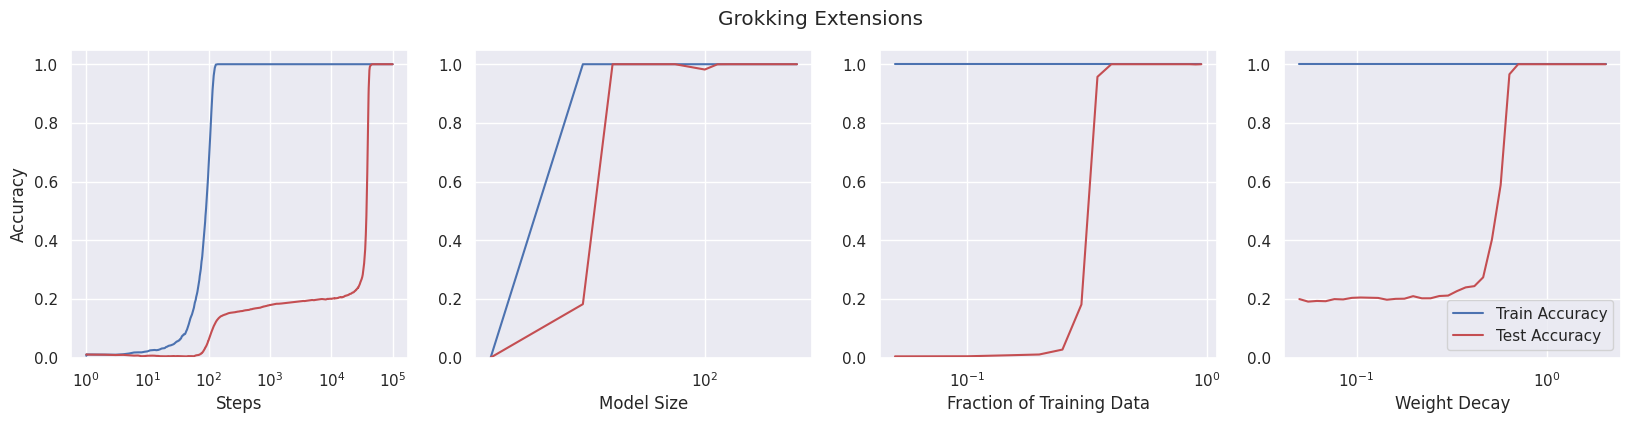

In [74]:
# Plot the 1x4 grid

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 4))

titles = ["Epoch-wise", "Model-wise", "Sample-wise", "Regularization-wise"]
xlabels = ["Steps", "Model Size", "Fraction of Training Data", "Weight Decay"]
ylabels = ["Accuracy", "", "", ""]
data = [(steps, ew_slice), (d_model_vals, mw_slice), (frac_train_vals, sw_slice), (wd_vals, rw_slice)]

for ax, title, xlabel, ylabel, (x, y) in zip(axes, titles, xlabels, ylabels, data):

    ax.set_ylim(0., 1.05)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    ax.plot(x, y["train/acc"], label="Train Accuracy", color=blue)
    ax.plot(x, y["test/acc"], label="Test Accuracy", color=red)

axes[0].set_xscale('log')
axes[1].set_xscale('log')
axes[2].set_xscale('log')
axes[3].set_xscale('log')

# Add a legend at the bottom of all the plots (to be shared)
# axes[0].legend(loc='upper center', bbox_to_anchor=(2.25, -0.3), fancybox=False, shadow=False, ncol=2)
# axes[3].legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), fancybox=False, shadow=False, ncol=2)
axes[3].legend()

fig.suptitle("Grokking Extensions")
fig.savefig("../figures/grokking_extensions.pdf", bbox_inches='tight')

In [12]:
from matplotlib import cm, colors, gridspec


blues = sns.dark_palette("#79C", as_cmap=True)
reds = sns.dark_palette((20, 60, 50), input="husl", as_cmap=True)

# Heatmap
def create_heatmap(
        x,
        y,
        z,
        ax, 
        smooth: Union[bool, float]=False, 
        cmap="inferno", 
        log_x: bool = True, 
        log_y: bool = True, 
        log_z: bool = True, 
        metric_label: str = "",
        title: str = ""
):
    X, Y = np.meshgrid(x, y)
    
    if smooth:
        z = gaussian_filter(z, sigma=float(smooth))
    
    if log_z:
        mesh = ax.pcolormesh(X, Y, z, cmap=cmap, norm=LogNorm())
    else:
        mesh = ax.pcolormesh(X, Y, z, cmap=cmap)

    if log_y:
        ax.set_yscale('log')

    if log_x:
        ax.set_xscale('log')

    ax.set_title(metric_label)
    ax.set_xlabel(title)
    ax.set_ylabel("Steps")
    ax.set_ylim(y.max(), y.min())
    ax.set_yticks([1, 10, 100, 1000, 10000, y.max()])
    ax.set_xlim(x[0], x[-1])
    ax.invert_yaxis()
    
    return mesh
    
def plot_details(
        df: pd.DataFrame,
        unique_col: str = "weight_decay", 
        smooth: Union[bool, float]=False, 
        log_loss=True, 
        cmap="inferno", 
        log_x: bool = True, 
        log_y: bool = True, 
        title: str = "",
        metric: str = "test/acc",
        metric_label: str = "Accuracy",
        step: int = 10000,
        run_val: float = 0.0, 
        plot_extra: bool = False,
):
    # Figure:
    # - Top Row: Heatmap stretching across
    # - Bottom Row: Two line plots.

    metric_label_short = metric_label.split(" ")[1] if " " in metric_label else metric_label

    # create a figure with a 2x2 grid of subplots
    fig = plt.figure(figsize=(10, 6))
    gs = gridspec.GridSpec(2, 4, width_ratios=[1.59, 6, 6, 1.59])

    pivot_table = get_pivot(df, unique_col, reindex=True, interpolate=True, columns=[metric])
    unique_vals = sorted(df[unique_col].unique())

    

    ax1 = plt.subplot(gs[0, 1:])
    mesh = create_heatmap(
        x=unique_vals,
        y=pivot_table[metric].index,
        z=pivot_table[metric].values,
        ax=ax1,
        smooth=smooth, 
        cmap=cmap, 
        log_x=log_x, 
        log_y=log_y,
        log_z=log_loss and "loss" in metric,
        title=title
    ) 

    fig.colorbar(mesh, ax=ax1)

    # Plot a vertical line at unique_col = run_val
    ax1.axvline(x=run_val, color=blue, linestyle='--', linewidth=1)

    # Plot a horizontal line at step = step
    ax1.axhline(y=step, color=red, linestyle='--', linewidth=1)

    # Line plots

    # Slice
    unique_vals, slice_ = extract_slice(df, step, unique_col)
    ax2 = plt.subplot(gs[1, 1])
    
    if plot_extra:
        num_steps = len(df._step.unique())
        # Plot one slice every 100 steps
        slices_table = pivot_table.loc[pivot_table.index % 10 == 0, :].T.reset_index()
        slices = pd.melt(slices_table, id_vars=[unique_col, 'level_0'], var_name='_step', value_name=metric)
        print(slices)

        sns.lineplot(data=slices, x=unique_col, y=metric, hue="_step", ax=ax2, alpha=100./num_steps, palette=reds, legend=False)
        slice_norm = colors.Normalize(vmin=0, vmax=df._step.max())
        slice_colorbar = cm.ScalarMappable(norm=slice_norm, cmap=reds)
        fig.colorbar(slice_colorbar, ax=ax2, label="Steps")
   
    ax2.plot(unique_vals, slice_[metric], label=title, color=red)
    ax2.set_xlabel(title)

    # Run example
    ax3 = plt.subplot(gs[1, 2])
    kwargs = {unique_col: run_val}
    steps, run = extract_run(df, **kwargs)

    if plot_extra:
        num_vals = len(unique_vals)
        sns.lineplot(data=df, x="_step", y=metric, hue=unique_col, ax=ax3, alpha=10./num_vals, palette=blues, legend=False)
        run_norm = colors.Normalize(vmin=min(unique_vals), vmax=max(unique_vals))
        run_colorbar = cm.ScalarMappable(norm=run_norm, cmap=blues)
        fig.colorbar(run_colorbar, ax=ax3, label=title)

    ax3.plot(steps, run[metric], label=title, color=blue)
    ax3.set_xlabel("Steps")

    for ax in [ax2, ax3]:
        if "Accuracy" in metric_label:
            ax.set_ylim(0.0, 1.05)
        else:
            min_loss, max_loss = df[metric].min(), df[metric].max()
            ax.set_ylim(min_loss - 0.5 * min_loss, max_loss + 0.5 * max_loss)
            ax.set_yscale('log')

        ax.set_ylabel(metric_label_short)
        ax.set_xscale('log')    

    # Adjust the layout of the subplots
    fig.suptitle(title)
    fig.tight_layout()

    return fig


def plot_all_details(
        df, 
        title, 
        unique_col, 
        run_val, 
        log_x=True, 
        log_y=True, 
        plot_extra=False,
        cmap="viridis",
        metrics_and_labels = [
            ("train/acc", "Train Accuracy"),
            ("test/acc", "Test Accuracy"),
            ("train/loss", "Train Loss"),
            ("test/loss", "Test Loss")
        ],
        format="png"
):

    for metric, label in metrics_and_labels:
        fig = plot_details(df, metric_label=label, metric=metric, title=title, unique_col=unique_col, run_val=run_val, cmap=cmap, log_x=log_x, log_y=log_y, plot_extra=plot_extra)
        slug = metric.replace("/", "_")
        fig.savefig(f"../figures/{unique_col}_{slug}.{format}", dpi=300)
        plt.show()


In [14]:
# Model-wise Details

plot_all_details(mw_grokking_cleaned, title="Transformer Embedding Dimension", unique_col="d_model", run_val=120, plot_extra=False)

NameError: name 'mw_grokking_cleaned' is not defined

/tmp/ipykernel_37893/1463713780.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.sort_values(by=unique_col, inplace=True)
/tmp/ipykernel_37893/1463713780.py:142: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.sort_values(by="_step", inplace=True)


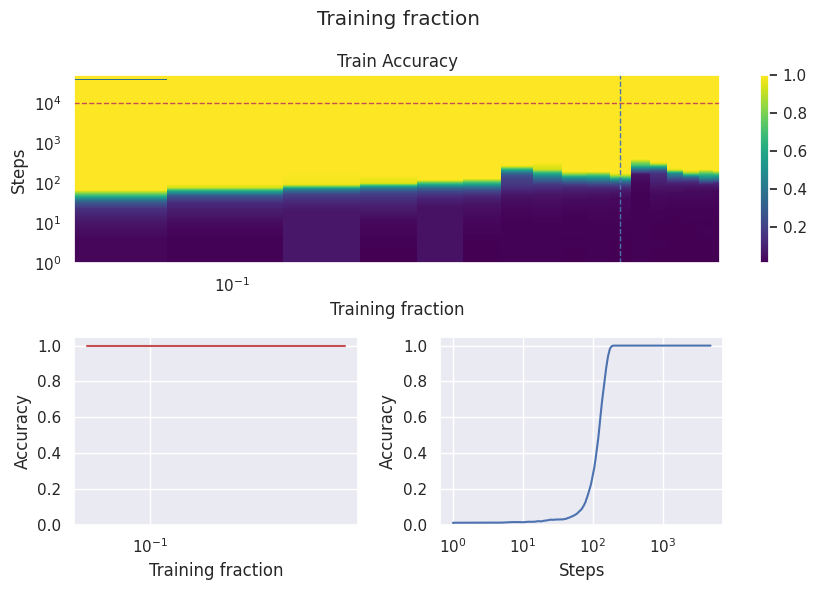

/tmp/ipykernel_37893/1463713780.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.sort_values(by=unique_col, inplace=True)
/tmp/ipykernel_37893/1463713780.py:142: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.sort_values(by="_step", inplace=True)


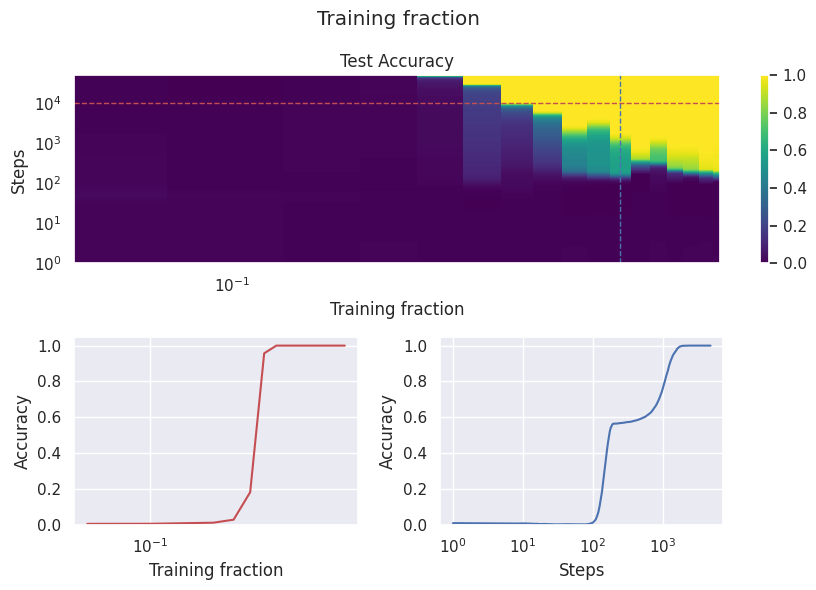

/tmp/ipykernel_37893/1463713780.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.sort_values(by=unique_col, inplace=True)
/tmp/ipykernel_37893/1463713780.py:142: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.sort_values(by="_step", inplace=True)


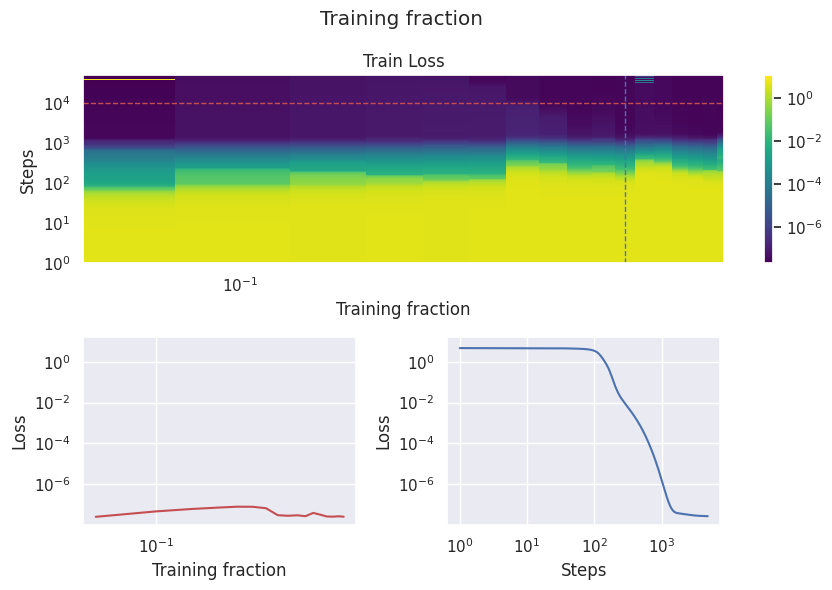

/tmp/ipykernel_37893/1463713780.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.sort_values(by=unique_col, inplace=True)
/tmp/ipykernel_37893/1463713780.py:142: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.sort_values(by="_step", inplace=True)


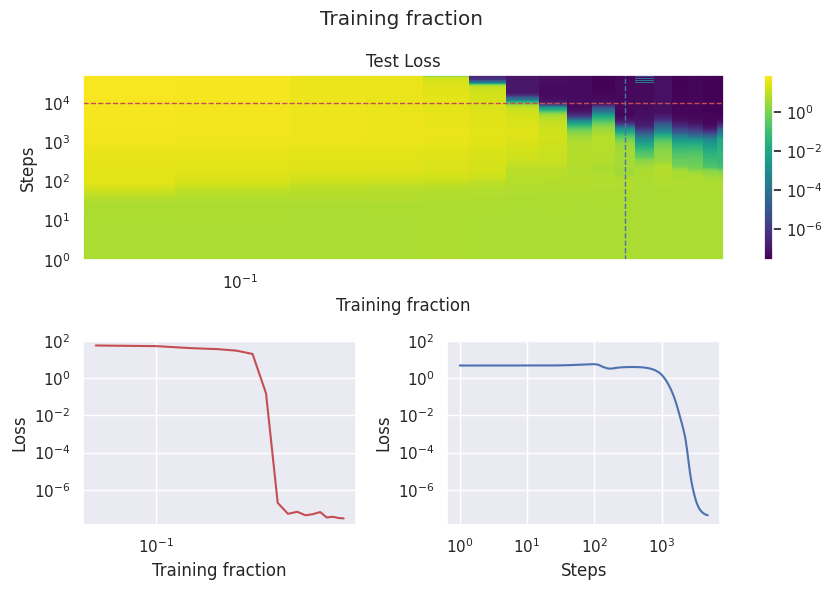

In [410]:
# Sample-wise Details

# plot_curves_2x2(sw_grokking_cleaned, title="Fraction of Training Data", unique_col="frac_train")

# plot_slice(sw_grokking_cleaned, 10000, log_loss=False, titles = {
#     "train/loss": "Train Loss",
#     "test/loss": "Validation Loss",
#     "train/acc": "Train Accuracy",
#     "test/acc": "Validation Accuracy"
# }, title="Fraction of Training Data", unique_col="frac_train", log_x=False)

# plot(sw_grokking_cleaned, smooth=0.25, log_loss=True, titles = {
#     "train/loss": "Train Loss",
#     "test/loss": "Validation Loss",
#     "train/acc": "Train Accuracy",
#     "test/acc": "Validation Accuracy"
# }, unique_col="frac_train", title="Training Fraction", log_x=False, log_y=False)

frac_trains = sw_grokking_cleaned.frac_train.unique()
frac_train_selection = frac_trains[10] 

frac_train_bads = frac_trains[-2:]
# Delete the bad run
sw_grokking_cleaned_2 = sw_grokking_cleaned[~sw_grokking_cleaned.frac_train.isin(frac_train_bads)]

plot_all_details(sw_grokking_cleaned_2, title="Training fraction", unique_col="frac_train", run_val=frac_train_selection, plot_extra=False)

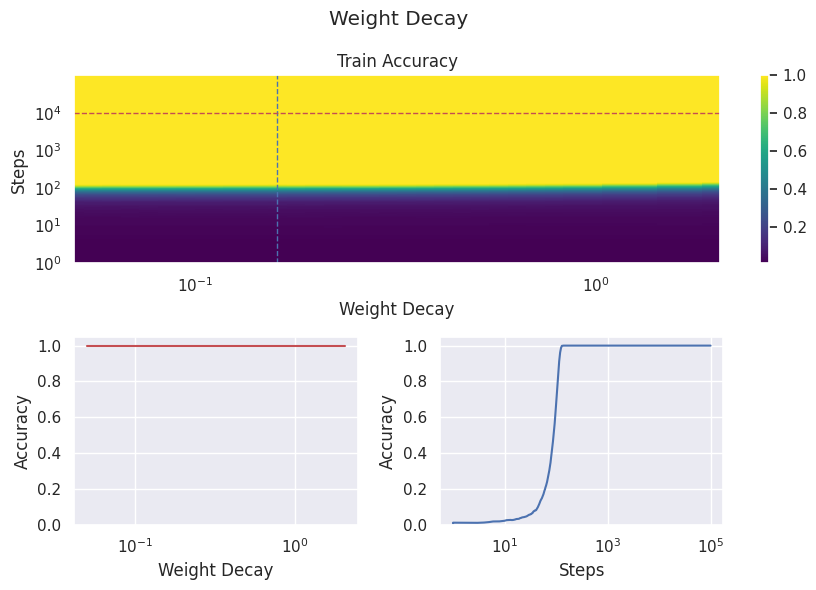

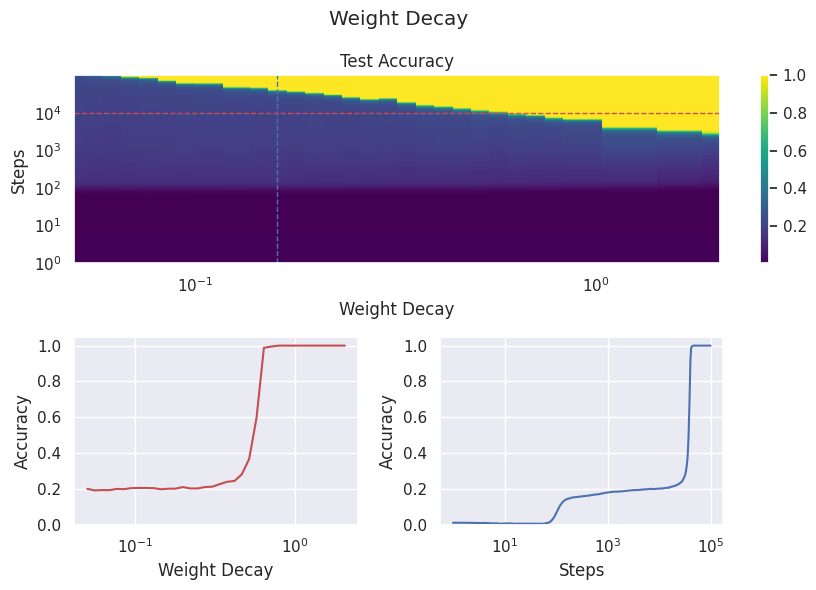

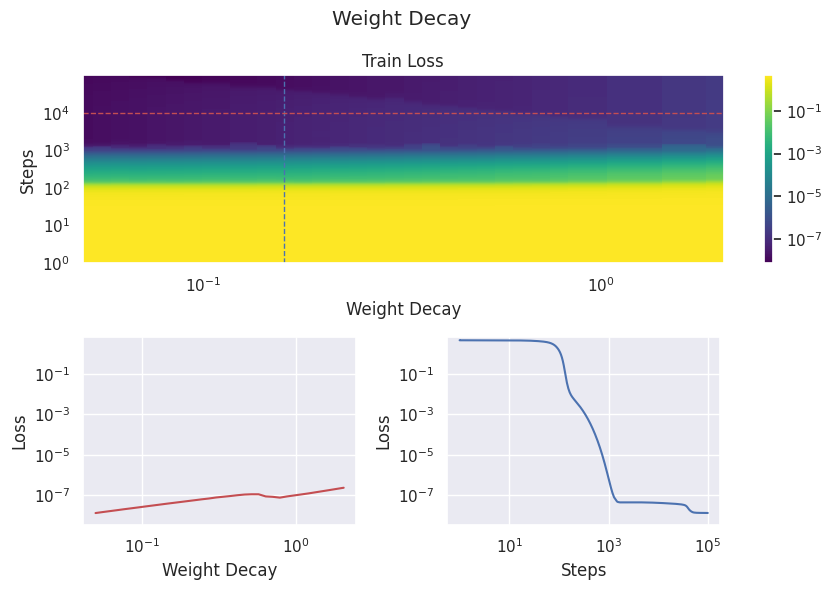

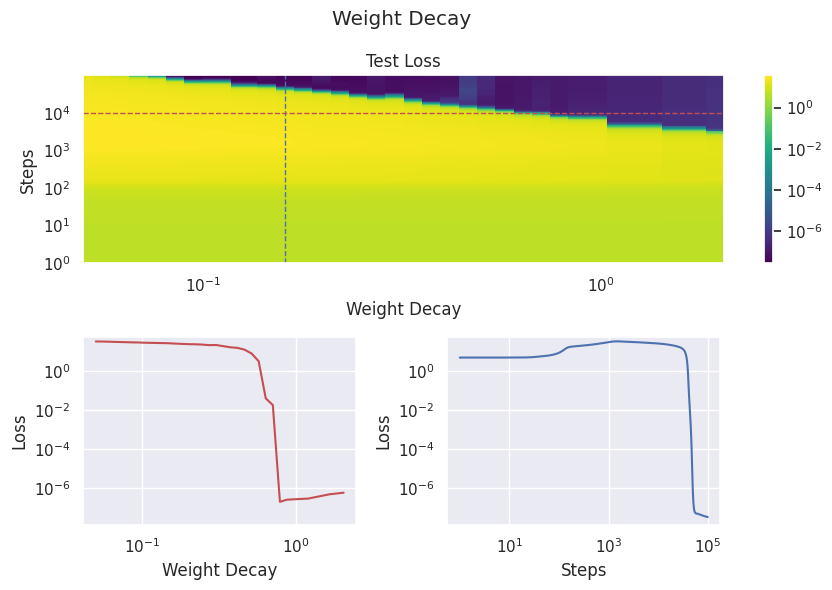

In [411]:
# Regularization-wises Details

# plot_curves_2x2(rw_grokking_cleaned, title="Weight Decay", unique_col="weight_decay")
# plot_slice(rw_grokking_cleaned, 10010, smooth=True, log_loss=False, titles = {
#     "train/loss": "Train Loss",
#     "test/loss": "Validation Loss",
#     "train/acc": "Train Accuracy",
#     "test/acc": "Validation Accuracy"
# }, title="Weight Decay")

# plot(rw_grokking_cleaned,   smooth=True, log_loss=False, titles = {
#     "train/loss": "Train Loss",
#     "test/loss": "Validation Loss",
#     "train/acc": "Train Accuracy",
#     "test/acc": "Validation Accuracy"
# }, title="Weight Decay")


plot_all_details(rw_grokking_cleaned, title="Weight Decay", unique_col="weight_decay", run_val=wd_selection, plot_extra=False)

## Interpolation

In [6]:
ln_sweep = get_history("xwna3rhg", allow_duplicates=True)

# ln_sweep_cleaned = handle_outliers(
#     ln_sweep,
#     loss_cols=["train/loss"], 
#     action="keep",
#     unique_cols=["frac_train"],
#     threshold=0.0001,
#     late_epochs_ratio=0.6,
# )


def correct_label_noise(df: pd.DataFrame):
    # Correct the sweeps by dividing test/acc by 1-label_noise
    df = df.copy()

    lbl_noises = df.frac_label_noise.unique()

    for lbl_noise in lbl_noises:
        for metric in ["test/acc"]:
            df.loc[df.frac_label_noise==lbl_noise, metric] /= 1 - lbl_noise

    return df

ln_sweep_cleaned = correct_label_noise(ln_sweep)

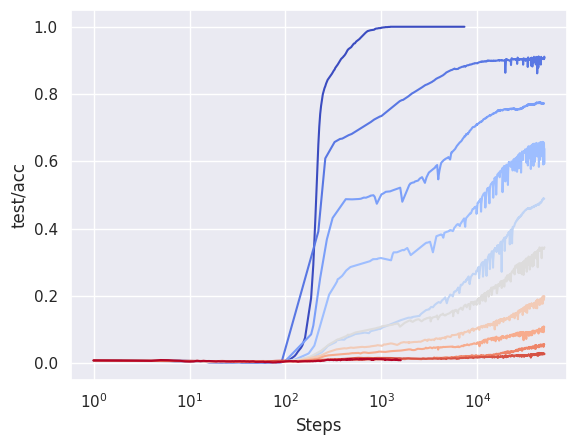

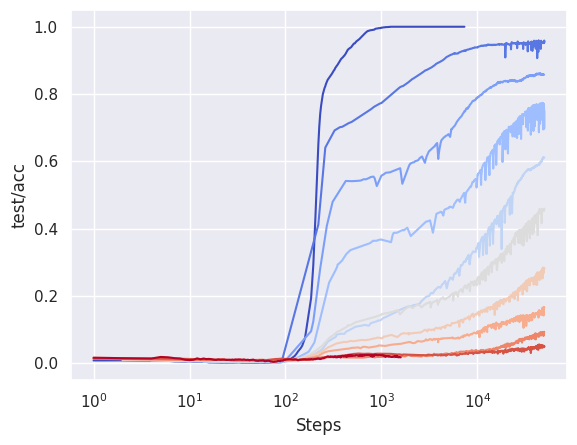

In [7]:
sns.lineplot(ln_sweep, x="_step", y="test/acc", hue="frac_label_noise", legend=False, palette="coolwarm", )
plt.xscale('log')
plt.xlabel("Steps")
plt.show()

sns.lineplot(ln_sweep_cleaned, x="_step", y="test/acc", hue="frac_label_noise", legend=False, palette="coolwarm", )
plt.xscale('log')
plt.xlabel("Steps")
plt.show()

In [43]:
frac_train_sweep = get_history("cnr2n43n", "759uhy5f", allow_duplicates=True, project="mnist-grokking")

[(220, 0.9550234951890803), (260, 0.9555829044528977), (425, 0.9998881181472364), (345, 0.9521145670172297), (380, 0.9777355113000671), (440, 0.9993287088834191), (410, 0.9793018572387558), (445, 0.9903781606623405), (645, 1.0), (520, 0.9978742447974938), (440, 0.9555829044528977)] [(520, 0.9504045941007571), (4920, 0.9119509816043634), (13530, 0.8196293395980162), (29280, 0.7400924347812735), (38140, 0.5820934481858523), (39230, 0.4367876098494736), (42360, 0.2703508968191819), (47050, 0.16023131136678515), (44450, 0.08874967371443489), (42420, 0.0526802876058945), (600, 0.02453667449752023)]


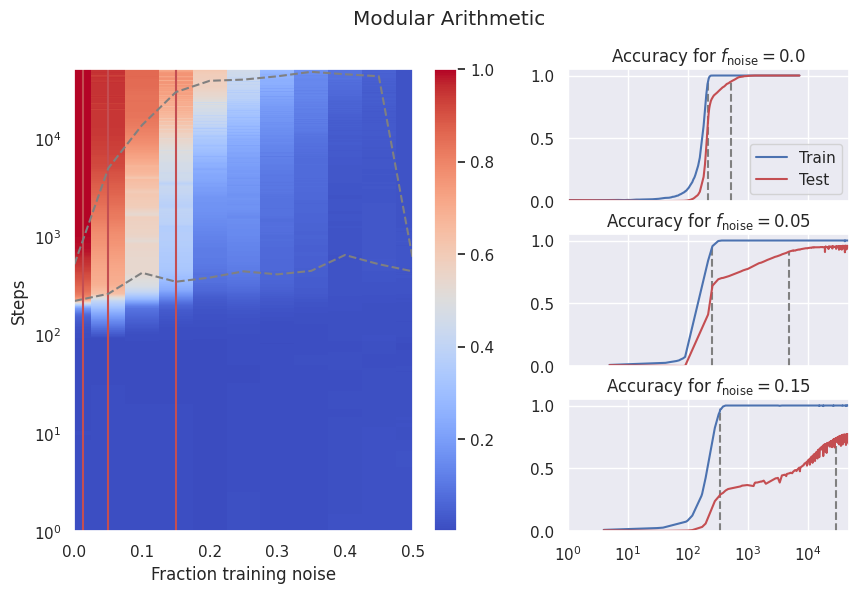

In [57]:
def plot_interpolation_overview(
        df: pd.DataFrame,
        unique_col: str = "weight_decay", 
        smooth: Union[bool, float]=False, 
        cmap="inferno", 
        log_loss=True, 
        log_x: bool = True, 
        log_y: bool = True, 
        title: str = "",
        metric: str = "test/acc",
        metric_label: str = "Accuracy",
        run_vals: List[float] = [0.0], 
        plot_extra: bool = False,        
        latex: str = "",    
        suptitle: str = "",
):
    
    metric_label_short = metric_label.split(" ")[1] if " " in metric_label else metric_label

    num_snapshots = len(run_vals)

    # create a figure with a 2x2 grid of subplots
    fig = plt.figure(figsize=(10, 6))
    gs = gridspec.GridSpec(num_snapshots, 2, width_ratios=[3, 2], hspace=0.25)

    pivot_table = get_pivot(df, unique_col, reindex=True, interpolate=True, columns=[metric])
    unique_vals = sorted(df[unique_col].unique())    

    ax1 = plt.subplot(gs[:, 0])
    y = pivot_table[metric].index
    mesh = create_heatmap(
        x=unique_vals,
        y=y,
        z=pivot_table[metric].values,
        ax=ax1,
        smooth=smooth, 
        cmap=cmap, 
        log_x=log_x, 
        log_y=log_y,
        log_z=log_loss and "loss" in metric,
        title=title
    ) 

    fig.colorbar(mesh, ax=ax1)

    # Plot horizontal lines at the run_vals entries
    run_vals_lines = [(v + 0.0125 if v == 0 else v) for v in run_vals]
    ax1.vlines(run_vals_lines, y.min(), y.max(), color=red)

    # Find the _step for each run where the train/acc first reaches 1.0
    interpolation = []
    convergence = []

    for i, val in enumerate(unique_vals):
        run = df.loc[(df[unique_col] == val), :]
        
        interp_max = run["train/acc"].max()
        interp_threshold = interp_max * .95
        interp_step = run.loc[run["train/acc"] > interp_threshold, "_step"].min()  # type: ignore
        interp_val = run.loc[run._step==interp_step, "train/acc"].values[0]  # type: ignore
        interpolation.append((interp_step, interp_val))

        conv_max = run[metric].max()
        conv_threshold = conv_max * .95
        conv_step = run.loc[run[metric] > conv_threshold, "_step"].min()  # type: ignore
        conv_val = run.loc[run._step==conv_step, metric].values[0]  # type: ignore
        convergence.append((conv_step, conv_val))

    print(interpolation, convergence)

    ax1.plot(unique_vals, [v for (v, _) in interpolation], color="grey", linestyle="--", label="Interpolation")
    ax1.plot(unique_vals, [v for (v, _) in convergence], color="grey", linestyle="--", label="Convergence")

    for i, val in enumerate(run_vals):
        run = df.loc[(df[unique_col] == val), :]
        ax = plt.subplot(gs[i, 1])

        # Interpolation threshold
        unique_val_idx = unique_vals.index(val)

        interp_step, interp_val = interpolation[unique_val_idx]
        ax.vlines(interp_step, 0, interp_val, color="grey", linestyle="--", label=None)

        # Test convergence threshold
        conv_step, conv_val = convergence[unique_val_idx]
        ax.vlines(conv_step, 0, conv_val, color="grey", linestyle="--", label=None)

        ax.plot(run._step, run["train/acc"], color=blue, label="Train")
        ax.plot(run._step, run[metric], color=red, label="Test")

        val_rounded = round(val, 2) 
        ax.set_title(f"{metric_label_short} for ${latex}={val_rounded}$")
        
        ax.set_ylim([0., 1.05])
        ax.set_xscale("log")
        ax.set_xlim([1e0, df._step.max()])
        
        if i < len(run_vals) - 1:
            ax.set_xticklabels([])

        if i == 0:
            ax.legend(loc="lower right")

    plt.suptitle(suptitle)


plot_interpolation_overview(
    ln_sweep_cleaned,
    unique_col="frac_label_noise",  
    title="Fraction training noise",
    cmap="coolwarm",
    run_vals=[0.0, 0.05, 0.15],
    latex=r"f_\mathrm{noise}",
    log_x=False,
    suptitle="Modular Arithmetic"
)   

[(345, 0.9550000000000001), (400, 0.9525), (490, 0.9545923632610939), (545, 0.9512195121951219), (625, 0.9577995478522985), (700, 0.9521072796934866), (1380, 0.9509881422924901), (1570, 0.9502724795640327), (1990, 0.9459261071690727), (2880, 0.9213240954580447), (3840, 0.9164231036882394), (1540, 0.8690333333333333)] [(29400, 0.78), (32800, 0.8345864661654134), (17000, 0.8198757763975155), (20300, 0.8870056497175142), (25300, 0.8461538461538463), (19200, 0.8160919540229885), (2400, 0.7458432304038005), (1050, 0.768916155419223), (1160, 0.8017621145374448), (1130, 0.7948243992606284), (1110, 0.8459290187891441), (1330, 0.8575)]


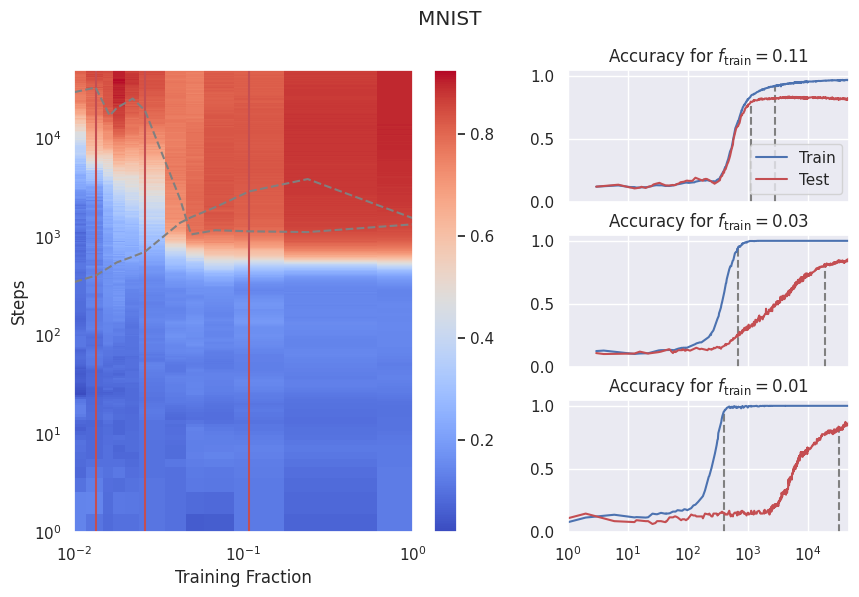

In [65]:
ft_vals = sorted(frac_train_sweep.frac_train.unique())
ft_selection = [ft_vals[-3], ft_vals[5], ft_vals[1]]

plot_interpolation_overview(
    frac_train_sweep,
    unique_col="frac_train",
    title="Training Fraction",
    cmap="coolwarm",
    run_vals=ft_selection,
    latex=r"f_\mathrm{train}",
    log_x=True,
    suptitle="MNIST"
) 

### Can we recreate grokking on MNIST?

In [ ]:
mnist_config = MNISTConfig(
    wandb_project="mnist-grokking",
    frac_train=1/60.,
    frac_label_noise=0.0,
    batch_size=200,
    num_training_steps=int(1e6),
    num_layers=2,
    width=200,
    init_mode="uniform",
    init_scale=6.,
    lr=1e-3, # 1e-3
    weight_decay=1e-2, # 1e-2
    seed=0,
    device=DEVICE,
    use_sgd=False
    # criterion="mse"
)

mnist_learner = MNISTLearner.create(
    mnist_config,
    mnist_train,
    mnist_test,
)

Model has 199210 trainable parameters


In [ ]:
try:
    wandb.init(
        project="mnist-grokking",
        settings=wandb.Settings(start_method="thread"),
        config=asdict(mnist_config),  # Default config
    )
    mnist_learner.train()
except KeyboardInterrupt:
    wandb.finish()

  0%|          | 0/200000 [00:00<?, ?it/s]

In [ ]:
mnist_dd_config = MNISTConfig(
    wandb_project="mnist-dd",
    frac_train=1.,
    frac_label_noise=0.2,
    batch_size=256,
    num_training_steps=int(60e3/256 * 1000),
    num_layers=2,
    width=200,
    init_mode="uniform",
    init_scale=1.,
    lr=1e-3, # 1e-3
    weight_decay=1e-2, # 1e-2
    seed=0,
    device=DEVICE,
    use_sgd=False
    # criterion="mse"
)

mnist_dd_learner = MNISTLearner.create(
    mnist_dd_config,
    mnist_train,
    mnist_test,
)

Model has 199210 trainable parameters


In [ ]:
try:
    wandb.init(
        project=mnist_dd_config.wandb_project,
        settings=wandb.Settings(start_method="thread"),
        config=asdict(mnist_dd_config),  # Default config
    )
    mnist_dd_learner.train()
except KeyboardInterrupt:
    wandb.finish()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: jqhoogland. Use `wandb login --relogin` to force relogin


  0%|          | 0/997 [00:00<?, ?it/s]

test/acc,▁▄▅▇▇▇▇▇▇▇▇▇▇█▇█▇███████████████████████
test/efficiency,█▆▅▄▄▄▃▄▃▃▃▃▃▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
test/loss,█▆▅▄▃▃▃▃▃▃▂▂▂▂▃▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/acc,▁▄▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇██████████████████████
train/efficiency,█▆▅▄▄▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
train/loss,█▆▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
weight/cos_sim_with_init,███▇▇▇▇▇▇▇▇▇▇▇▇▆▆▆▆▆▆▆▆▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▁▁
weight/dist_from_init,▁▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
weight/norm,▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▆▆▆▆▇▇▇██
test/acc,0.7946
test/efficiency,0.02905


### Can we induce grokking in CIFAR-10?

In [ ]:
# Transform to black & white & crop to 28 x 28 & normalize

cifar_train_bw = CIFAR10(root="../data", train=True, download=True, transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914,), (0.2023,)),
    transforms.Grayscale(),
    transforms.CenterCrop(28),
]))
cifar_test_bw = CIFAR10(root="../data", train=False, download=True, transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914,), (0.2023,)),
    transforms.Grayscale(),
    transforms.CenterCrop(28),
]))

# First try with the MNIST model

cifar_config_bw = MNISTConfig(
    wandb_project="cifar-grokking",
    frac_train=1/60.,
    frac_label_noise=0.0,
    batch_size=200,
    num_training_steps=int(1e6),
    num_layers=2,
    width=200,
    init_mode="uniform",
    init_scale=6.,
    lr=1e-3, # 1e-3
    weight_decay=1e-2, # 1e-2
    seed=0,
    device=DEVICE,
    use_sgd=False
    # criterion="mse"
)

cifar_learner_bw = MNISTLearner.create(
    cifar_config_bw,
    cifar_train_bw,
    cifar_test_bw,
)

def run(learner: BaseLearner, config: Config):
    try:
        wandb.init(
            project=config.wandb_project,
            settings=wandb.Settings(start_method="thread"),
            config=asdict(config),
        )
        learner.train()
    except KeyboardInterrupt:
        wandb.finish()

# run(cifar_config_bw, cifar_learner_bw)

Files already downloaded and verified
Files already downloaded and verified
Model has 199210 trainable parameters


In [ ]:
class ResBlock(ExtModule):
    def __init__(self, in_channels, out_channels, kernel_size=3, use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=1, stride=strides)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, padding=1)
        
        if use_1x1conv:
            self.conv3 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=strides)
        else:
            self.conv3 = None

        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        
        if self.conv3:
            x = self.conv3(x)
        
        out += x
        return F.relu(out)

class ResNet(ExtModule):
    def __init__(
        self, 
        num_blocks: int,
        num_classes: int,
        in_channels: int = 3,
        in_width: int = 32,
        init_scale: float = 1.,
    ):
        super().__init__()

        self.in_width = in_width
        self.in_channels = in_channels
        self.num_blocks = num_blocks
        self.num_classes = num_classes
        self.init_scale = init_scale
        
        self.conv1 = nn.Conv2d(in_channels, 32, kernel_size=5, stride=2, padding=0, bias=False)
        size = (in_width - 5) // 2 + 1

        self.bn1 = nn.BatchNorm2d(32)

        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        size = (size - 3) // 2 + 1

        resblocks = [
            ResBlock(32 * (2 ** i), 32 * (2 ** (i + 1)), strides=2, kernel_size=3)
            for i in range(num_blocks)
        ]

        for i, _ in enumerate(resblocks):
            size = (size - 3) // 2 + 1

        self.resblocks = nn.Sequential(*resblocks)

        self.flatten = nn.Flatten()
        num_channels = 32 * (2 ** num_blocks)
        self.fc1 = nn.Linear(num_channels * size, num_classes)

        self.init_weights()

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)

        out = self.maxpool(out)
        out = self.resblocks(out)
        out = self.flatten(out)
        out = self.fc1(out)
        return out
    

@dataclass
class CIFARConfig(VisionConfig):
    num_blocks: int = 2
    num_classes: int = 10
    in_channels: int = 3
    in_width: int = 32 


class CIFARLearner(BaseLearner):
    Config = CIFARConfig
    Dataset = Union[CIFAR10, Subset[CIFAR10]]

    @classmethod
    def create(
        cls,
        config: Config,
        trainset: Dataset,
        testset: Dataset,
    ) -> "BaseLearner":
        torch.manual_seed(config.seed)
        model = cls.get_model(config)
        optimizer = cls.get_optimizer(config, model)
        trainloader = cls.get_loader(config, trainset)
        testloader = cls.get_loader(config, testset, train=False)
        return cls(model, optimizer, config, trainloader, testloader)

    @staticmethod
    def get_loader(config: Config, dataset: Dataset, train=True) -> DataLoader[Dataset]:
        def add_label_noise(dataset: CIFARLearner.Dataset, frac_label_noise: float) -> CIFARLearner.Dataset:
            num_samples = len(dataset)
            num_errors = int(num_samples * frac_label_noise)
            
            origin_indices = torch.randperm(num_samples)[:num_errors]
            target_indices = origin_indices.roll(1)

            for origin, target in zip(origin_indices, target_indices):
                dataset.targets[origin] = dataset.targets[target]  # TODO: Make this not in-place

            return dataset

        if config.frac_label_noise > 0.0:
            dataset = add_label_noise(dataset, config.frac_label_noise)

        if train and config.frac_train < 1.0:
            dataset = Subset(
                dataset, 
                list(range(int(len(dataset) * config.frac_train)))
            )

        return DataLoader(
            dataset,
            batch_size=config.batch_size,
            shuffle=train,
        )

    @classmethod
    def get_model(cls, config: Config) -> nn.Module:
        model = ResNet(
            num_blocks=config.num_blocks,
            num_classes=config.num_classes,
            in_channels=config.in_channels,
            in_width=config.in_width,
            init_scale=config.init_scale,
        )

        if config.load_path is not None:
            model.load_state_dict(torch.load(config.load_path))

        model.to(config.device)

        num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
        print(f"Model has {num_params} trainable parameters")

        return model

cifar_config = CIFARConfig(
    batch_size=256,
    wandb_project="cifar10-grokking",
    frac_train=0.0167,
    init_scale=8.,
    frac_label_noise=0.2,
    num_training_steps=int(60000. / 256 * 200),
)

cifar_train = CIFAR10(root="../data", train=True, download=True, transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914,), (0.2023,)),
]))
cifar_test = CIFAR10(root="../data", train=False, download=True, transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914,), (0.2023,)),
]))

cifar_learner = CIFARLearner.create(
    cifar_config,
    trainset=cifar_train,
    testset=cifar_test,
)    

run(cifar_learner, cifar_config)

Files already downloaded and verified
Files already downloaded and verified
Model has 280106 trainable parameters


RuntimeError: The size of tensor a (4) must match the size of tensor b (7) at non-singleton dimension 3

### Can we interpolate just by varying initialization scale and label noise?

## Miscellaneous


### Can we induce epoch-/regularization-wise DD in shallow models?

### Can we induce epoch-wise DD in transformers?